In [1]:
from google.colab import drive
drive.mount('/content/drive')




Mounted at /content/drive


In [2]:
# Install dependencies
!pip install torch torchvision torchaudio torch-geometric optuna dgllife pandas scikit-learn tensorboard rdkit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 54.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 37.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.1/226.1 kB 20.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.4/36.4 MB 23.8 MB/s eta 0:00:00


In [ ]:
# then update path
CSV_PATH = "/content/drive/MyDrive/Pegah_works/modified_data_final.csv"

In [3]:
#Go to your working directory
%cd /content/drive/MyDrive/Pegah_works

/content/drive/MyDrive/Pegah_works


In [ ]:
# ===========================================================
# Graph Joint Autoencoder + Regressor + Ensemble + HPO (PyG)
# ===========================================================
# - PyTorch 2.6 / PyG 2.5 compatible
# - R²-first hyperparameter search with tie-break on MAE
# - Denoising AE pretrain (node feature recon: BCE on binary, MSE on cont.)
# - Joint fine-tune with supervised + light reconstruction
# - CosineAnnealingWarmRestarts + SWA, ensemble across diverse seeds
# - Saves HPO log and final artifacts (+ target transformer for inference)
# ===========================================================

import os, json, random, numpy as np, pandas as pd, torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import random_split
from torch.optim.swa_utils import AveragedModel, SWALR, update_bn
from sklearn.preprocessing import PowerTransformer
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import KFold

from rdkit import Chem, RDLogger
from rdkit.Chem import rdchem
RDLogger.DisableLog('rdApp.*')

from torch_geometric.data import Data, InMemoryDataset
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GINEConv, global_mean_pool, BatchNorm

import joblib

# ---------------------------
# Reproducibility / Device
# ---------------------------
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ---------------------------
# Paths
# ---------------------------
CSV_PATH = "/content/drive/MyDrive/Pegah_works/validation_datasset/modified_data_final_2.csv"
HPO_LOG_PATH = "graph_hpo_log.json"
ARTIFACT_PATH = "option4b_graph_joint_ae_regressor_ensemble.pt"
PT_PATH = "target_transform.joblib"

# ---------------------------
# Base Config (can be overridden by HPO)
# ---------------------------
BASE_CFG = dict(
    # Featurization
    atom_nums=[1,6,7,8,9,15,16,17,35,53],
    max_degree=5,
    charges=[-2,-1,0,1,2],
    hybs=[rdchem.HybridizationType.SP, rdchem.HybridizationType.SP2, rdchem.HybridizationType.SP3,
          rdchem.HybridizationType.SP3D, rdchem.HybridizationType.SP3D2],
    bond_types=[rdchem.BondType.SINGLE, rdchem.BondType.DOUBLE, rdchem.BondType.TRIPLE, rdchem.BondType.AROMATIC],
    force_reprocess=False,

    # Encoder (GNN)
    enc_hidden=128,
    enc_layers=3,
    enc_dropout=0.10,

    # AE pretrain
    ae_lr=1e-3,
    ae_weight_decay=1e-5,
    ae_epochs=150,
    ae_batch_size=64,
    ae_feat_drop=0.10,

    # Regressor (Dense + SE)
    growth=256,
    n_blocks=4,
    dropout=0.28,
    head_hidden=384,

    # Joint training
    lr=1.05e-3,
    weight_decay=9e-4,
    batch_size=32,
    epochs=600,
    T0=70,
    Tmult=1,
    swa_ratio=0.33,

    # Loss mix
    alpha=0.65,
    sup_weight=0.90,
    recon_weight=0.10,

    # Data split / ensemble
    val_split=0.10,
    ensemble_size=10
)

# ---------------------------
# Atom / Bond Features
# ---------------------------
def atom_features(atom, cfg):
    nums, hybs, charges, max_deg = cfg["atom_nums"], cfg["hybs"], cfg["charges"], cfg["max_degree"]
    f_num = [1.0 if atom.GetAtomicNum()==z else 0.0 for z in nums] + [0.0]
    if sum(f_num[:-1]) == 0: f_num[-1] = 1.0
    d = atom.GetTotalDegree()
    f_deg = [1.0 if d==k else 0.0 for k in range(max_deg+1)] + [1.0 if d>max_deg else 0.0]
    ch = atom.GetFormalCharge()
    f_ch = [1.0 if ch==c else 0.0 for c in charges] + [1.0 if ch not in charges else 0.0]
    hyb = atom.GetHybridization()
    f_hy = [1.0 if hyb==h else 0.0 for h in hybs] + [1.0 if hyb not in hybs else 0.0]
    f_bin_misc = [float(atom.GetIsAromatic()), float(atom.IsInRing())]
    f_cont = [float(atom.GetTotalNumHs(includeNeighbors=True)), float(atom.GetImplicitValence())]
    return np.array(f_num + f_deg + f_ch + f_hy + f_bin_misc + f_cont, dtype=np.float32)

def bond_features(bond, cfg):
    btypes = cfg["bond_types"]
    f_bt = [1.0 if bond.GetBondType()==t else 0.0 for t in btypes] + [0.0]
    if sum(f_bt[:-1]) == 0: f_bt[-1] = 1.0
    f_misc = [float(bond.GetIsConjugated()), float(bond.IsInRing())]
    return np.array(f_bt + f_misc, dtype=np.float32)

def get_atom_feature_dims(cfg):
    bin_dim = (len(cfg["atom_nums"])+1) + (cfg["max_degree"]+1+1) + (len(cfg["charges"])+1) + (len(cfg["hybs"])+1) + 2
    cont_dim = 2
    return bin_dim, cont_dim

def smiles_to_pyg(smiles, y, cfg):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None: return None
    Chem.Kekulize(mol, clearAromaticFlags=False)
    x = torch.tensor(np.vstack([atom_features(a, cfg) for a in mol.GetAtoms()]), dtype=torch.float32)

    ei_src, ei_dst, eattr = [], [], []
    for b in mol.GetBonds():
        i, j = b.GetBeginAtomIdx(), b.GetEndAtomIdx()
        bf = bond_features(b, cfg)
        ei_src += [i, j]; ei_dst += [j, i]
        eattr.append(bf); eattr.append(bf)

    if len(ei_src) == 0:
        edge_index = torch.empty((2,0), dtype=torch.long)
        edge_attr  = torch.empty((0, len(cfg["bond_types"]) + 2 + 1), dtype=torch.float32)
    else:
        edge_index = torch.tensor([ei_src, ei_dst], dtype=torch.long)
        edge_attr  = torch.tensor(np.vstack(eattr), dtype=torch.float32)

    return Data(x=x, edge_index=edge_index, edge_attr=edge_attr,
                y=torch.tensor([float(y)], dtype=torch.float32))

# ---------------------------
# Dataset
# ---------------------------
class GraphDataset(InMemoryDataset):
    def __init__(self, csv_path, cfg, force_reprocess=False):
        self.csv_path = csv_path
        self.cfg = cfg
        self._procdir = ".proc_graph_pt26"
        os.makedirs(self._procdir, exist_ok=True)
        super().__init__(self._procdir)
        fname = self.processed_paths[0]
        if force_reprocess or (not os.path.exists(fname)):
            self.process()
        try:
            self.data, self.slices = torch.load(fname, weights_only=False)
        except Exception:
            self.process()
            self.data, self.slices = torch.load(fname, weights_only=False)

    @property
    def processed_file_names(self):
        base = os.path.splitext(os.path.basename(self.csv_path))[0]
        return [f"{base}_graphs.pt"]

    def process(self):
        df = pd.read_csv(self.csv_path)
        smiles = df.iloc[:, 0].astype(str).tolist()
        num_feats = df.iloc[:, 1:-1].astype(float).values
        targets = df.iloc[:, -1].astype(float).tolist()

        data_list = []
        for s, nf, t in zip(smiles, num_feats, targets):
            d = smiles_to_pyg(s, t, self.cfg)
            if d is not None:
                # store as (4,) per graph; batching may flatten -> we reshape in forward robustly
                d.num_feats = torch.tensor(nf, dtype=torch.float32)
                data_list.append(d)
        data, slices = self.collate(data_list)
        torch.save((data, slices), self.processed_paths[0])

# ---------------------------
# Target Transform (list-safe, warning-free)
# ---------------------------
def _iter_y(dataset):
    if isinstance(dataset, list):
        return np.array([float(d.y.item()) for d in dataset], dtype=np.float32).reshape(-1, 1)
    else:
        y = torch.stack([dataset.get(i).y for i in range(len(dataset))]).cpu().numpy().reshape(-1, 1)
        return y.astype(np.float32)

def fit_target_transform(dataset):
    y = _iter_y(dataset)
    pt = PowerTransformer(method="yeo-johnson", standardize=True)
    y_t = pt.fit_transform(y).astype(np.float32)

    if isinstance(dataset, list):
        for i in range(len(dataset)):
            dataset[i].y = torch.tensor([y_t[i, 0]], dtype=torch.float32)
    else:
        # write to underlying storage and clear cached list
        dataset._data.y = torch.tensor(y_t, dtype=torch.float32).view(-1, 1)
        dataset._data_list = None
    return pt

def inverse_target(pt, y_np):
    y_np = np.asarray(y_np, dtype=np.float64)
    y_np = np.nan_to_num(y_np, nan=0.0, posinf=10.0, neginf=-10.0)
    y_np = np.clip(y_np, -10, 10)
    try:
        inv = pt.inverse_transform(y_np.reshape(-1,1)).ravel()
    except Exception:
        inv = y_np
    inv = np.nan_to_num(inv, nan=0.0, posinf=np.finfo(np.float32).max/2, neginf=np.finfo(np.float32).min/2)
    return inv.astype(np.float32)

# ---------------------------
# Model Definitions
# ---------------------------
class GNNEncoder(nn.Module):
    def __init__(self, in_dim, hidden, layers, dropout, edge_dim):
        super().__init__()
        self.convs = nn.ModuleList()
        self.bns = nn.ModuleList()
        last = in_dim
        for _ in range(layers):
            mlp = nn.Sequential(nn.Linear(last, hidden), nn.ReLU(), nn.Linear(hidden, hidden))
            self.convs.append(GINEConv(mlp, edge_dim=edge_dim))
            self.bns.append(BatchNorm(hidden))
            last = hidden
        self.dropout = dropout
        self.out_dim = hidden

    def forward(self, x, edge_index, edge_attr):
        for conv, bn in zip(self.convs, self.bns):
            x = conv(x, edge_index, edge_attr)
            x = bn(x)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)
        return x

class NodeFeatDecoder(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, in_dim),
            nn.ReLU(),
            nn.Linear(in_dim, out_dim)
        )
    def forward(self, h_nodes):
        return self.net(h_nodes)

class SEBlock(nn.Module):
    def __init__(self, dim, reduction=8):
        super().__init__()
        hidden = max(4, dim // reduction)
        self.fc1 = nn.Linear(dim, hidden)
        self.fc2 = nn.Linear(hidden, dim)
    def forward(self, x):
        w = torch.sigmoid(self.fc2(F.relu(self.fc1(x))))
        return x * w

class DenseSERegressor(nn.Module):
    def __init__(self, in_dim, growth, n_blocks, dropout, head_hidden):
        super().__init__()
        layers = []
        layers.append(nn.Sequential(
            nn.Linear(in_dim, growth),
            nn.BatchNorm1d(growth),
            nn.ReLU(),
            nn.Dropout(dropout)
        ))
        for _ in range(n_blocks - 1):
            layers.append(nn.Sequential(
                nn.Linear(growth, growth),
                nn.BatchNorm1d(growth),
                nn.ReLU(),
                nn.Dropout(dropout)
            ))
        self.blocks = nn.Sequential(*layers)
        self.se = SEBlock(growth, reduction=8)
        self.head = nn.Sequential(
            nn.Linear(growth, head_hidden),
            nn.BatchNorm1d(head_hidden),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(head_hidden, 1)
        )

    def forward(self, z):
        h = self.blocks(z)
        h = self.se(h)
        return self.head(h)

class JointGraphAER(nn.Module):
    def __init__(self, node_in, edge_in, cfg, num_extra_feats=4):
        super().__init__()
        self.encoder = GNNEncoder(node_in, cfg["enc_hidden"], cfg["enc_layers"], cfg["enc_dropout"], edge_in)
        self.decoder = NodeFeatDecoder(cfg["enc_hidden"], node_in)
        self.num_extra_feats = num_extra_feats
        self.regressor = DenseSERegressor(
            in_dim=cfg["enc_hidden"] + num_extra_feats,
            growth=cfg["growth"],
            n_blocks=cfg["n_blocks"],
            dropout=cfg["dropout"],
            head_hidden=cfg["head_hidden"]
        )

    def forward(self, data):
        x, edge_index, edge_attr, batch = data.x, data.edge_index, data.edge_attr, data.batch
        h_nodes = self.encoder(x, edge_index, edge_attr)
        z_graph = global_mean_pool(h_nodes, batch)  # (B, enc_hidden)

        # -------- FIX: robust batching of num_feats --------
        if self.num_extra_feats > 0:
            if hasattr(data, "num_feats") and data.num_feats is not None:
                nf = data.num_feats.to(z_graph.device)

                # PyG may flatten graph-level attributes into 1D (B*F,)
                if nf.dim() == 1:
                    nf = nf.view(z_graph.size(0), -1)

                # If it came as (B, F) but F mismatched, clamp/pad
                if nf.size(0) != z_graph.size(0):
                    # last resort: try reshape using B
                    nf = nf.reshape(z_graph.size(0), -1)

                if nf.size(1) > self.num_extra_feats:
                    nf = nf[:, :self.num_extra_feats]
                elif nf.size(1) < self.num_extra_feats:
                    pad = torch.zeros(z_graph.size(0), self.num_extra_feats - nf.size(1), device=z_graph.device)
                    nf = torch.cat([nf, pad], dim=1)

                z_graph = torch.cat([z_graph, nf], dim=1)
            else:
                pad = torch.zeros(z_graph.size(0), self.num_extra_feats, device=z_graph.device)
                z_graph = torch.cat([z_graph, pad], dim=1)

        y_hat = self.regressor(z_graph)
        x_logits = self.decoder(h_nodes)
        return y_hat, x_logits, h_nodes, z_graph

# ---------------------------
# Data Loaders (list-safe)
# ---------------------------
def make_split_loaders(dataset, cfg, seed):
    n = len(dataset)
    n_val = max(1, int(cfg["val_split"] * n))
    n_tr = max(1, n - n_val)

    gen = torch.Generator().manual_seed(seed)

    if isinstance(dataset, list):
        idx = torch.randperm(n, generator=gen).tolist()
        tr_idx = idx[:n_tr]
        va_idx = idx[n_tr:n_tr+n_val]
        tr_ds = [dataset[i] for i in tr_idx]
        va_ds = [dataset[i] for i in va_idx]
    else:
        tr_ds, va_ds = random_split(dataset, [n_tr, n_val], generator=gen)

    bs_tr = min(cfg["batch_size"], len(tr_ds)); bs_tr = bs_tr if bs_tr > 0 else 1
    bs_va = min(cfg["batch_size"], len(va_ds)); bs_va = bs_va if bs_va > 0 else 1
    tr_loader = DataLoader(tr_ds, batch_size=bs_tr, shuffle=True, drop_last=False)
    va_loader = DataLoader(va_ds, batch_size=bs_va, shuffle=False, drop_last=False)
    return tr_loader, va_loader

def eval_ensemble(models, loader, pt):
    yhat_all, ytrue_all = [], []
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            preds = []
            for m in models:
                y_hat, _, _, _ = m(data)
                preds.append(y_hat.squeeze(1).cpu().numpy())
            p_mean = np.mean(preds, axis=0)
            yhat_all.append(p_mean)
            ytrue_all.append(data.y.cpu().numpy().ravel())
    y_pred = np.concatenate(yhat_all)
    y_true = np.concatenate(ytrue_all)
    y_pred_inv = inverse_target(pt, y_pred)
    y_true_inv = inverse_target(pt, y_true)
    mae = mean_absolute_error(y_true_inv, y_pred_inv)
    mse = mean_squared_error(y_true_inv, y_pred_inv)
    rmse = float(np.sqrt(mse))
    r2 = r2_score(y_true_inv, y_pred_inv)
    return dict(mae=mae, mse=mse, rmse=rmse, r2=r2)

# ---------------------------
# Training Loops
# ---------------------------
def pretrain_encoder(dataset, cfg, bin_dim, cont_dim, epochs_override=None, seed=SEED):
    torch.manual_seed(seed); np.random.seed(seed); random.seed(seed)

    sample = dataset[0] if isinstance(dataset, list) else dataset.get(0)
    node_in = sample.x.shape[1]
    edge_in = sample.edge_attr.shape[1] if sample.edge_attr is not None and sample.edge_attr.numel() > 0 else 0

    model = JointGraphAER(node_in, edge_in, cfg, num_extra_feats=0).to(device)

    params = list(model.encoder.parameters()) + list(model.decoder.parameters())
    opt = torch.optim.AdamW(params, lr=cfg["ae_lr"], weight_decay=cfg["ae_weight_decay"])
    sched = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(opt, T_0=40, T_mult=1)
    bce = nn.BCEWithLogitsLoss(); mse = nn.MSELoss()

    tr_loader, _ = make_split_loaders(dataset, cfg, seed)
    E = epochs_override if epochs_override is not None else cfg["ae_epochs"]

    for epoch in range(E):
        model.train()
        for data in tr_loader:
            data = data.to(device)
            opt.zero_grad()
            _, x_logits, _, _ = model(data)
            x_bin = data.x[:, :bin_dim]; x_cont = data.x[:, bin_dim:bin_dim+cont_dim]
            xl_bin = x_logits[:, :bin_dim]; xl_cont = x_logits[:, bin_dim:bin_dim+cont_dim]
            loss = bce(xl_bin, x_bin) + mse(xl_cont, x_cont)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            opt.step()
        sched.step(epoch)

    return {"encoder": model.encoder.state_dict(),
            "decoder": model.decoder.state_dict(),
            "node_in": node_in,
            "edge_in": edge_in}

def train_single_joint(dataset, pt, ae_init, cfg, seed_offset, bin_dim, cont_dim, epochs_override=None):
    seed = SEED + seed_offset
    torch.manual_seed(seed); np.random.seed(seed); random.seed(seed)

    tr_loader, va_loader = make_split_loaders(dataset, cfg, seed)
    model = JointGraphAER(ae_init["node_in"], ae_init["edge_in"], cfg, num_extra_feats=4).to(device)
    model.encoder.load_state_dict(ae_init["encoder"])
    model.decoder.load_state_dict(ae_init["decoder"])

    optimizer = torch.optim.AdamW(model.parameters(), lr=cfg["lr"], weight_decay=cfg["weight_decay"])
    scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=cfg["T0"], T_mult=cfg["Tmult"])

    E = epochs_override if epochs_override is not None else cfg["epochs"]
    swa_start_epoch = int((1.0 - cfg["swa_ratio"]) * E)
    swa_model = AveragedModel(model)
    swa_scheduler = SWALR(optimizer, swa_lr=cfg["lr"] * 0.1)

    sl1 = nn.SmoothL1Loss(); mse = nn.MSELoss(); bce = nn.BCEWithLogitsLoss()

    for epoch in range(E):
        model.train()

        if epoch == 0:
            sample_data = next(iter(tr_loader)).to(device)
            with torch.no_grad():
                _, _, _, z_graph_dbg = model(sample_data)
            print(f"[DEBUG] Epoch {epoch} — z_graph: {z_graph_dbg.shape}, "
                  f"Regressor in_features: {model.regressor.blocks[0][0].in_features}")

        for data in tr_loader:
            data = data.to(device)
            optimizer.zero_grad()
            y_hat, x_logits, _, _ = model(data)

            sup = cfg["alpha"] * sl1(y_hat, data.y.unsqueeze(1)) + (1.0 - cfg["alpha"]) * mse(y_hat, data.y.unsqueeze(1))

            x_bin = data.x[:, :bin_dim]; x_cont = data.x[:, bin_dim:bin_dim+cont_dim]
            xl_bin = x_logits[:, :bin_dim]; xl_cont = x_logits[:, bin_dim:bin_dim+cont_dim]
            recon = bce(xl_bin, x_bin) + mse(xl_cont, x_cont)

            loss = cfg["sup_weight"] * sup + cfg["recon_weight"] * recon
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()

        if epoch < swa_start_epoch:
            scheduler.step(epoch)
        else:
            swa_model.update_parameters(model)
            swa_scheduler.step()

    update_bn(tr_loader, swa_model, device=device)
    return swa_model, va_loader

# ---------------------------
# CV Pipeline (list-safe)
# ---------------------------
def run_cv_pipeline(cfg, n_splits=5):
    print(f"\n=== {n_splits}-Fold Cross-Validation ===")
    ds = GraphDataset(CSV_PATH, cfg, force_reprocess=cfg.get("force_reprocess", False))
    bin_dim, cont_dim = get_atom_feature_dims(cfg)

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=SEED)
    indices = np.arange(len(ds))
    metrics_list = []

    for fold, (train_idx, val_idx) in enumerate(kf.split(indices), 1):
        print(f"\n--- Fold {fold}/{n_splits} ---")

        tr_list = [ds[int(i)] for i in train_idx]
        va_list = [ds[int(i)] for i in val_idx]

        pt_fold = fit_target_transform(tr_list)  # fit ONLY on training fold
        # apply same transform to val fold
        y_val = np.array([float(d.y.item()) for d in va_list], dtype=np.float32).reshape(-1, 1)
        y_val_t = pt_fold.transform(y_val).astype(np.float32)
        for i in range(len(va_list)):
            va_list[i].y = torch.tensor([y_val_t[i, 0]], dtype=torch.float32)

        ae_init = pretrain_encoder(tr_list, cfg, bin_dim, cont_dim, epochs_override=cfg["ae_epochs"], seed=SEED+fold)
        model, _ = train_single_joint(tr_list, pt_fold, ae_init, cfg, seed_offset=fold*11,
                                      bin_dim=bin_dim, cont_dim=cont_dim, epochs_override=cfg["epochs"])

        va_loader = DataLoader(va_list, batch_size=min(cfg["batch_size"], len(va_list)), shuffle=False)
        metrics = eval_ensemble([model], va_loader, pt_fold)
        metrics_list.append(metrics)

        print(f"[Fold {fold}] R²={metrics['r2']:.4f}  MAE={metrics['mae']:.4f}  RMSE={metrics['rmse']:.4f}")

    r2s = [m["r2"] for m in metrics_list]
    maes = [m["mae"] for m in metrics_list]
    rmses = [m["rmse"] for m in metrics_list]

    summary = {
        "R2_mean": float(np.mean(r2s)),
        "R2_std": float(np.std(r2s)),
        "MAE_mean": float(np.mean(maes)),
        "MAE_std": float(np.std(maes)),
        "RMSE_mean": float(np.mean(rmses)),
        "RMSE_std": float(np.std(rmses))
    }

    print("\n=== CV Summary ===")
    print(f"R²:   {summary['R2_mean']:.4f} ± {summary['R2_std']:.4f}")
    print(f"MAE:  {summary['MAE_mean']:.4f} ± {summary['MAE_std']:.4f}")
    print(f"RMSE: {summary['RMSE_mean']:.4f} ± {summary['RMSE_std']:.4f}")
    return summary, metrics_list

# ---------------------------
# HPO: R²-first Random Search
# ---------------------------
def sample_cfg(base):
    cfg = dict(base)

    cfg["enc_hidden"]   = random.choice([128, 160, 192, 224, 256])
    cfg["enc_layers"]   = random.choice([3, 4, 5])
    cfg["enc_dropout"]  = random.choice([0.05, 0.08, 0.10, 0.12, 0.15])

    cfg["growth"]       = random.choice([192, 224, 256, 320])
    cfg["n_blocks"]     = random.choice([3, 4, 5])
    cfg["dropout"]      = random.choice([0.10, 0.15, 0.20, 0.25])
    cfg["head_hidden"]  = random.choice([256, 320, 384, 512])

    cfg["lr"]           = random.choice([7e-4, 9e-4, 1e-3, 1.2e-3])
    cfg["weight_decay"] = random.choice([1e-4, 5e-4, 9e-4, 1.2e-3])
    cfg["batch_size"]   = random.choice([24, 32, 48])

    cfg["T0"]           = random.choice([70, 100, 120, 150])
    cfg["Tmult"]        = random.choice([1, 2])
    cfg["swa_ratio"]    = random.choice([0.25, 0.30, 0.33, 0.40])

    cfg["alpha"]        = random.choice([0.60, 0.65, 0.70, 0.80])
    sup_w               = random.choice([0.90, 0.92, 0.95])
    cfg["sup_weight"]   = sup_w
    cfg["recon_weight"] = 1.0 - sup_w

    cfg["ae_epochs"]    = random.choice([80, 100, 120])
    cfg["ae_feat_drop"] = random.choice([0.05, 0.10, 0.15])

    return cfg

def quick_eval(cfg, dataset, bin_dim, cont_dim, hpo_ae_epochs=80, hpo_joint_epochs=220, seed_offset=0):
    pt = fit_target_transform(dataset)
    ae_init = pretrain_encoder(dataset, cfg, bin_dim, cont_dim, epochs_override=hpo_ae_epochs, seed=SEED + seed_offset)
    model, va_loader = train_single_joint(dataset, pt, ae_init, cfg, seed_offset=seed_offset,
                                          bin_dim=bin_dim, cont_dim=cont_dim, epochs_override=hpo_joint_epochs)
    metrics = eval_ensemble([model], va_loader, pt)
    return metrics, model

def hpo_random_search(base_cfg, n_trials=20, hpo_ae_epochs=80, hpo_joint_epochs=220):
    ds = GraphDataset(CSV_PATH, base_cfg, force_reprocess=base_cfg.get("force_reprocess", False))
    bin_dim, cont_dim = get_atom_feature_dims(base_cfg)

    logs = []
    best_cfg = None
    best_met = None

    for t in range(n_trials):
        cfg = sample_cfg(base_cfg)
        # IMPORTANT: create a fresh list copy for each trial to avoid y-transform compounding
        trial_list = [ds[i] for i in range(len(ds))]

        metrics, _ = quick_eval(cfg, trial_list, bin_dim, cont_dim,
                                hpo_ae_epochs=hpo_ae_epochs,
                                hpo_joint_epochs=hpo_joint_epochs,
                                seed_offset=t*97)

        logs.append({"trial": t, "cfg": cfg, "metrics": metrics})
        print(f"[HPO {t:02d}] R2={metrics['r2']:.4f}  MAE={metrics['mae']:.4f}  RMSE={metrics['rmse']:.4f}")

        if (best_met is None) or (metrics["r2"] > best_met["r2"] + 1e-6) or \
           (abs(metrics["r2"] - best_met["r2"]) < 1e-6 and metrics["mae"] < best_met["mae"]):
            best_cfg = cfg
            best_met = metrics

    with open(HPO_LOG_PATH, "w") as f:
        json.dump({"logs": logs, "best_cfg": best_cfg, "best_metrics": best_met}, f, indent=2)

    print(f"[HPO] Best R2={best_met['r2']:.4f}, MAE={best_met['mae']:.4f}, RMSE={best_met['rmse']:.4f}")
    return best_cfg, best_met

# ---------------------------
# Final Training (Full) + Ensemble
# ---------------------------
def run_pipeline(cfg):
    print("Loading dataset...")
    ds = GraphDataset(CSV_PATH, cfg, force_reprocess=cfg.get("force_reprocess", False))
    ds_list = [ds[i] for i in range(len(ds))]  # list = safest for y-transform + HPO-like behavior

    pt = fit_target_transform(ds_list)
    joblib.dump(pt, PT_PATH)

    bin_dim, cont_dim = get_atom_feature_dims(cfg)

    print("Pretraining Graph Encoder (denoising recon)...")
    ae_init = pretrain_encoder(ds_list, cfg, bin_dim, cont_dim, epochs_override=cfg["ae_epochs"], seed=SEED)

    print("Joint fine-tuning + Ensemble...")
    models = []
    val_loader_ref = None
    for i in range(cfg["ensemble_size"]):
        m, v = train_single_joint(ds_list, pt, ae_init, cfg, seed_offset=i*123, bin_dim=bin_dim, cont_dim=cont_dim)
        models.append(m)
        val_loader_ref = v

    metrics = eval_ensemble(models, val_loader_ref, pt)
    return metrics, models, ae_init, pt

# ---------------------------
# Main
# ---------------------------
if __name__ == "__main__":
    print("=== GRAPH JOINT AE + REGRESSOR + ENSEMBLE (with HPO) ===")
    print("Base config:")
    for k, v in BASE_CFG.items():
        print(f"  {k}: {v}")

    print("\n=== HPO: Random Search ===")
    best_cfg, best_hpo_metrics = hpo_random_search(
        BASE_CFG,
        n_trials=20,
        hpo_ae_epochs=80,
        hpo_joint_epochs=220
    )

    FINAL_CFG = dict(BASE_CFG)
    FINAL_CFG.update(best_cfg)
    FINAL_CFG["ae_epochs"] = max(120, FINAL_CFG.get("ae_epochs", BASE_CFG["ae_epochs"]))
    FINAL_CFG["epochs"] = max(600, FINAL_CFG.get("epochs", BASE_CFG["epochs"]))
    FINAL_CFG["ensemble_size"] = BASE_CFG["ensemble_size"]

    print("\n=== Final Training with Best Config (Full) ===")
    for k, v in FINAL_CFG.items():
        print(f"  {k}: {v}")

    print("\n=== 5-Fold Cross-Validation with Best Config ===")
    cv_summary, fold_metrics = run_cv_pipeline(FINAL_CFG, n_splits=5)

    metrics, models, ae_init, pt = run_pipeline(FINAL_CFG)

    print("\nFinal Ensemble Metrics (Validation):")
    print(f"  MAE:  {metrics['mae']:.4f}")
    print(f"  RMSE: {metrics['rmse']:.4f}")
    print(f"  MSE:  {metrics['mse']:.6f}")
    print(f"  R²:   {metrics['r2']:.4f}")

    torch.save({
        "config": FINAL_CFG,
        "best_hpo_metrics": best_hpo_metrics,
        "power_transformer_path": PT_PATH,
        "target_transform_lambdas": getattr(pt, "lambdas_", None),
        "ae_encoder_state": ae_init["encoder"],
        "ae_decoder_state": ae_init["decoder"],
        "joint_states": [m.state_dict() for m in models],
    }, ARTIFACT_PATH)

    print(f"\nSaved artifacts: {ARTIFACT_PATH}")
    print(f"HPO log: {HPO_LOG_PATH}")
    print(f"Target transform (for inference): {PT_PATH}")


=== GRAPH JOINT AE + REGRESSOR + ENSEMBLE (with HPO) ===
Base config:
  atom_nums: [1, 6, 7, 8, 9, 15, 16, 17, 35, 53]
  max_degree: 5
  charges: [-2, -1, 0, 1, 2]
  hybs: [rdkit.Chem.rdchem.HybridizationType.SP, rdkit.Chem.rdchem.HybridizationType.SP2, rdkit.Chem.rdchem.HybridizationType.SP3, rdkit.Chem.rdchem.HybridizationType.SP3D, rdkit.Chem.rdchem.HybridizationType.SP3D2]
  bond_types: [rdkit.Chem.rdchem.BondType.SINGLE, rdkit.Chem.rdchem.BondType.DOUBLE, rdkit.Chem.rdchem.BondType.TRIPLE, rdkit.Chem.rdchem.BondType.AROMATIC]
  force_reprocess: False
  enc_hidden: 128
  enc_layers: 3
  enc_dropout: 0.1
  ae_lr: 0.001
  ae_weight_decay: 1e-05
  ae_epochs: 150
  ae_batch_size: 64
  ae_feat_drop: 0.1
  growth: 256
  n_blocks: 4
  dropout: 0.28
  head_hidden: 384
  lr: 0.00105
  weight_decay: 0.0009
  batch_size: 32
  epochs: 600
  T0: 70
  Tmult: 1
  swa_ratio: 0.33
  alpha: 0.65
  sup_weight: 0.9
  recon_weight: 0.1
  val_split: 0.1
  ensemble_size: 10

=== HPO: Random Search ===
[D

In [18]:
import pandas as pd

# ---------------------------
# Path
# ---------------------------
EXT_PATH = "/content/drive/MyDrive/Pegah_works/validation_datasset/External_VALID.csv"

# ---------------------------
# Load dataset
# ---------------------------
df = pd.read_csv(EXT_PATH)

# ---------------------------
# Rename columns (consistent naming)
# ---------------------------
df = df.rename(columns={
    "SMILES": "SMILES(modred)",
    "Block_A": "Block A (x)",
    "Block_B": "Block B (1-x)",
    "A/B_ratio": "Block A/B ratio",
    "polymer_type": "Polymer type",
    "conductivity": "Membrane Anion Conductivity [S/cm]"
})

# ---------------------------
# Normalize block fractions
# ---------------------------
#df["Block A (x)"] = df["Block A (x)"].astype(float) / 100.0
#df["Block B (1-x)"] = df["Block B (1-x)"].astype(float) / 100.0

# ---------------------------
# Define polymer identity
# ---------------------------
group_cols = [
    "SMILES(modred)",
    "Block A (x)",
    "Block B (1-x)",
    "Block A/B ratio",
    "Polymer type"
]

# ---------------------------
# Aggregate: mean conductivity ONLY
# ---------------------------
polymer_df = (
    df.groupby(group_cols, as_index=False)
      .agg({"Membrane Anion Conductivity [S/cm]": "mean"})
)

# ---------------------------
# Save
# ---------------------------
OUT_PATH = (
    "/content/drive/MyDrive/Pegah_works/validation_datasset/"
    "External_VALID_POLYMER_MEAN_ONLY.csv"
)
polymer_df.to_csv(OUT_PATH, index=False)

print(f"Saved polymer-level mean dataset with {len(polymer_df)} polymers:")
print(OUT_PATH)


Saved polymer-level mean dataset with 20 polymers:
/content/drive/MyDrive/Pegah_works/validation_datasset/External_VALID_POLYMER_MEAN_ONLY.csv


In [13]:
# ===========================================================
# External Dataset Examination ONLY (NO MODEL, NO PREDICTION)
# ===========================================================
# - Target distribution
# - Replicate structure
# - Experimental spread within replicates
# - Saves clean summary CSVs
# ===========================================================

import numpy as np
import pandas as pd

# ---------------------------
# Path
# ---------------------------
EXT_PATH = "/content/drive/MyDrive/Pegah_works/validation_datasset/modified_data_final_2.csv"

# ---------------------------
# Load dataset
# ---------------------------
df = pd.read_csv(EXT_PATH)

# ---------------------------
# Rename columns (exactly as used earlier)
# ---------------------------
df = df.rename(columns={
    "SMILES": "SMILES(modred)",
    "Block_A": "Block A (x)",
    "Block_B": "Block B (1-x)",
    "A/B_ratio": "Block A/B ratio",
    "polymer_type": "Polymer type",
    "conductivity": "Membrane Anion Conductivity [S/cm]"
})

# ---------------------------
# Normalize block fractions
# ---------------------------
df["Block A (x)"] = df["Block A (x)"].astype(float) / 100.0
df["Block B (1-x)"] = df["Block B (1-x)"].astype(float) / 100.0

# ---------------------------
# Basic sanity checks
# ---------------------------
print("\n=== Dataset shape ===")
print(df.shape)

print("\n=== First 5 rows ===")
print(df.head())

print("\n=== Block sum check (should be 1.0) ===")
print((df["Block A (x)"] + df["Block B (1-x)"]).describe())

# ---------------------------
# Target distribution
# ---------------------------
y = df["Membrane Anion Conductivity [S/cm]"].astype(float).values

print("\n=== Target distribution (External dataset) ===")
print(f"Count : {len(y)}")
print(f"Min   : {y.min():.6f}")
print(f"Max   : {y.max():.6f}")
print(f"Mean  : {y.mean():.6f}")
print(f"Std   : {y.std(ddof=0):.6f}  (population)")
print(f"Std   : {y.std(ddof=1):.6f}  (sample)")

# ---------------------------
# Define replicate identity (what makes a polymer unique)
# ---------------------------
group_cols = [
    "SMILES(modred)",
    "Block A (x)",
    "Block B (1-x)",
    "Block A/B ratio",
    "Polymer type"
]

# ---------------------------
# Replicate counts
# ---------------------------
rep_counts = (
    df.groupby(group_cols)
      .size()
      .reset_index(name="n_measurements")
)

print("\n=== Replicate counts per unique polymer ===")
print("Unique polymers:", len(rep_counts))
print(rep_counts["n_measurements"].value_counts().sort_index())

print("\nFraction of dataset with replicates (>1 measurement):")
frac_rep = rep_counts.loc[rep_counts["n_measurements"] > 1, "n_measurements"].sum() / len(df)
print(f"{frac_rep*100:.1f}%")

# ---------------------------
# Experimental spread within replicates
# ---------------------------
spread = (
    df.groupby(group_cols)
      .agg(
          n=("Membrane Anion Conductivity [S/cm]", "size"),
          y_mean=("Membrane Anion Conductivity [S/cm]", "mean"),
          y_std=("Membrane Anion Conductivity [S/cm]", "std"),
          y_min=("Membrane Anion Conductivity [S/cm]", "min"),
          y_max=("Membrane Anion Conductivity [S/cm]", "max"),
      )
      .reset_index()
)

# Fill NaN std for single-measurement polymers
spread["y_std"] = spread["y_std"].fillna(0.0)
spread["y_range"] = spread["y_max"] - spread["y_min"]

print("\n=== Experimental variability (within same polymer) ===")
print(f"Median std   : {np.median(spread['y_std']):.6f}")
print(f"Mean std     : {np.mean(spread['y_std']):.6f}")
print(f"Median range: {np.median(spread['y_range']):.6f}")
print(f"Mean range  : {np.mean(spread['y_range']):.6f}")

# ---------------------------
# Most variable polymers
# ---------------------------
print("\n=== Top 10 most variable polymers (by range) ===")
print(
    spread.sort_values("y_range", ascending=False)
          .head(10)[
              [
                  "SMILES(modred)",
                  "Block A (x)",
                  "Block B (1-x)",
                  "Block A/B ratio",
                  "Polymer type",
                  "n",
                  "y_mean",
                  "y_std",
                  "y_min",
                  "y_max",
                  "y_range"
              ]
          ]
)

# ---------------------------
# Save clean summaries
# ---------------------------
#rep_counts.to_csv("external_replicate_counts.csv", index=False)
#spread.to_csv("external_experimental_spread.csv", index=False)




=== Dataset shape ===
(207, 6)

=== First 5 rows ===
                                      SMILES(modred)  Block A (x)  \
0  CC1=CC=C(C=C1)C(C2=CC=C(C=C2)OC3=CC=C(C=C3)C(C...     0.001980   
1  CC1=CC=C(C(C2=CC=C(OC3=CC=C(C(C)(CCC(NCC4=CC=[...     0.005020   
2  CC1=CC=C(C(C2=CC=C(OC3=CC=C(C(C)(CCC(NCC4=CC=[...     0.007581   
3  CC1=CC=C(C(C2=CC=C(OC3=CC=C(C(C)(CCC(NCC4=CC=[...     0.009670   
4  COC1=C(C[N+]2=C(CC)N=CC2)C=C(OC3=CC(C[N+]4=C(C...     0.001500   

   Block B (1-x)  Block A/B ratio  Polymer type  \
0       0.008020            0.247             1   
1       0.004980            1.008             1   
2       0.002419            3.134             1   
3       0.000330           29.303             1   
4       0.008500            0.176             1   

   Membrane Anion Conductivity [S/cm]  
0                             0.00318  
1                             0.00616  
2                             0.01026  
3                             0.01156  
4                       

In [15]:
# ===========================================================
# External Dataset Examination ONLY (NO MODEL, NO PREDICTION)
# ===========================================================
# - Target distribution
# - Replicate structure
# - Experimental spread within replicates
# - Saves clean summary CSVs
# ===========================================================

import numpy as np
import pandas as pd

# ---------------------------
# Path
# ---------------------------
EXT_PATH = "/content/drive/MyDrive/Pegah_works/validation_datasset/External_VALID_POLYMER_MEAN_ONLY.csv"

# ---------------------------
# Load dataset
# ---------------------------
df = pd.read_csv(EXT_PATH)

# ---------------------------
# Rename columns (exactly as used earlier)
# ---------------------------
df = df.rename(columns={
    "SMILES": "SMILES(modred)",
    "Block_A": "Block A (x)",
    "Block_B": "Block B (1-x)",
    "A/B_ratio": "Block A/B ratio",
    "polymer_type": "Polymer type",
    "conductivity": "Membrane Anion Conductivity [S/cm]"
})

# ---------------------------
# Normalize block fractions
# ---------------------------
df["Block A (x)"] = df["Block A (x)"].astype(float) / 100.0
df["Block B (1-x)"] = df["Block B (1-x)"].astype(float) / 100.0

# ---------------------------
# Basic sanity checks
# ---------------------------
print("\n=== Dataset shape ===")
print(df.shape)

print("\n=== First 5 rows ===")
print(df.head())

print("\n=== Block sum check (should be 1.0) ===")
print((df["Block A (x)"] + df["Block B (1-x)"]).describe())

# ---------------------------
# Target distribution
# ---------------------------
y = df["Membrane Anion Conductivity [S/cm]"].astype(float).values

print("\n=== Target distribution (External dataset) ===")
print(f"Count : {len(y)}")
print(f"Min   : {y.min():.6f}")
print(f"Max   : {y.max():.6f}")
print(f"Mean  : {y.mean():.6f}")
print(f"Std   : {y.std(ddof=0):.6f}  (population)")
print(f"Std   : {y.std(ddof=1):.6f}  (sample)")

# ---------------------------
# Define replicate identity (what makes a polymer unique)
# ---------------------------
group_cols = [
    "SMILES(modred)",
    "Block A (x)",
    "Block B (1-x)",
    "Block A/B ratio",
    "Polymer type"
]

# ---------------------------
# Replicate counts
# ---------------------------
rep_counts = (
    df.groupby(group_cols)
      .size()
      .reset_index(name="n_measurements")
)

print("\n=== Replicate counts per unique polymer ===")
print("Unique polymers:", len(rep_counts))
print(rep_counts["n_measurements"].value_counts().sort_index())

print("\nFraction of dataset with replicates (>1 measurement):")
frac_rep = rep_counts.loc[rep_counts["n_measurements"] > 1, "n_measurements"].sum() / len(df)
print(f"{frac_rep*100:.1f}%")

# ---------------------------
# Experimental spread within replicates
# ---------------------------
spread = (
    df.groupby(group_cols)
      .agg(
          n=("Membrane Anion Conductivity [S/cm]", "size"),
          y_mean=("Membrane Anion Conductivity [S/cm]", "mean"),
          y_std=("Membrane Anion Conductivity [S/cm]", "std"),
          y_min=("Membrane Anion Conductivity [S/cm]", "min"),
          y_max=("Membrane Anion Conductivity [S/cm]", "max"),
      )
      .reset_index()
)

# Fill NaN std for single-measurement polymers
spread["y_std"] = spread["y_std"].fillna(0.0)
spread["y_range"] = spread["y_max"] - spread["y_min"]

print("\n=== Experimental variability (within same polymer) ===")
print(f"Median std   : {np.median(spread['y_std']):.6f}")
print(f"Mean std     : {np.mean(spread['y_std']):.6f}")
print(f"Median range: {np.median(spread['y_range']):.6f}")
print(f"Mean range  : {np.mean(spread['y_range']):.6f}")

# ---------------------------
# Most variable polymers
# ---------------------------
print("\n=== Top 10 most variable polymers (by range) ===")
print(
    spread.sort_values("y_range", ascending=False)
          .head(10)[
              [
                  "SMILES(modred)",
                  "Block A (x)",
                  "Block B (1-x)",
                  "Block A/B ratio",
                  "Polymer type",
                  "n",
                  "y_mean",
                  "y_std",
                  "y_min",
                  "y_max",
                  "y_range"
              ]
          ]
)

# ---------------------------
# Save clean summaries
# ---------------------------
#rep_counts.to_csv("external_replicate_counts.csv", index=False)
#spread.to_csv("external_experimental_spread.csv", index=False)

print("\nSaved files:")
print(" - external_replicate_counts.csv")
print(" - external_experimental_spread.csv")



=== Dataset shape ===
(20, 6)

=== First 5 rows ===
                                      SMILES(modred)  Block A (x)  \
0                         C(C)C[N+](C)(C)CCCCCCNC(C)         0.87   
1                      C(C)C[N+]1(CCCCCCNC(C))CCCCC1         0.87   
2  C1=CC(C[N+](C)(C)C)=C(C(C)=C1)OC1=CC(C)=C(C(C)...         0.64   
3  C1=CC(C[N+](C)(C)C)=C(C(C)=C1)OC1=CC(C)=C(C(C)...         0.67   
4  C1=CC(C[N+](C)(C)C)=C(C(C)=C1)OC1=CC(C)=C(C(C)...         0.73   

   Block B (1-x)  Block A/B ratio  Polymer type  \
0           0.13         6.692308           1.0   
1           0.13         6.692308           1.0   
2           0.36         1.777778           1.0   
3           0.33         2.030303           1.0   
4           0.27         2.703704           1.0   

   Membrane Anion Conductivity [S/cm]  
0                             0.08217  
1                             0.04349  
2                             0.01290  
3                             0.01860  
4                        

In [19]:
# ===========================================================
# External Inference + Ensemble Metrics (FINAL – SWA unwrap + PT2.6 load)
# ===========================================================
# Fixes in this version:
# 1) torch.load: PT 2.6 -> must use weights_only=False for your checkpoint
# 2) SWA AveragedModel state_dict keys are prefixed with "module." and include "n_averaged"
#    -> we unwrap keys before loading into a normal nn.Module
# 3) Your saved BN keys show "encoder.bns.X.module.*" (from PyG BatchNorm wrapper)
#    -> model definition matches your TRAINING model exactly (with BatchNorm from torch_geometric.nn)
# 4) node_in/edge_in are computed from config (no fragile state_dict probing)
# ===========================================================

import torch
import numpy as np
import pandas as pd
import joblib

from rdkit import Chem, RDLogger
from rdkit.Chem import rdchem
RDLogger.DisableLog("rdApp.*")

from torch_geometric.data import Data
from torch_geometric.loader import DataLoader

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GINEConv, global_mean_pool, BatchNorm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# -----------------------------------------------------------
# Paths
# -----------------------------------------------------------
ARTIFACT_PATH = "option4b_graph_joint_ae_regressor_ensemble.pt"
PT_PATH = "target_transform.joblib"
EXT_PATH = "/content/drive/MyDrive/Pegah_works/validation_datasset/External_VALID_POLYMER_MEAN_ONLY.csv"

# -----------------------------------------------------------
# Load checkpoint (trusted)
# -----------------------------------------------------------
ckpt = torch.load(ARTIFACT_PATH, map_location=device, weights_only=False)
FINAL_CFG = ckpt["config"]
joint_states = ckpt["joint_states"]
pt = joblib.load(PT_PATH)

# -----------------------------------------------------------
# Unwrap SWA / DDP-ish state_dict (module. prefix + n_averaged)
# -----------------------------------------------------------
def unwrap_swa_state_dict(state_dict):
    new_sd = {}
    for k, v in state_dict.items():
        if k == "n_averaged":
            continue
        if k.startswith("module."):
            k = k[len("module."):]
        new_sd[k] = v
    return new_sd

# -----------------------------------------------------------
# Feature dims (match training)
# -----------------------------------------------------------
def get_atom_feature_dims(cfg):
    bin_dim = (
        (len(cfg["atom_nums"]) + 1) +
        (cfg["max_degree"] + 1 + 1) +
        (len(cfg["charges"]) + 1) +
        (len(cfg["hybs"]) + 1) +
        2
    )
    cont_dim = 2
    return bin_dim + cont_dim

def get_edge_feature_dims(cfg):
    return len(cfg["bond_types"]) + 1 + 2

node_in = get_atom_feature_dims(FINAL_CFG)
edge_in = get_edge_feature_dims(FINAL_CFG)

# -----------------------------------------------------------
# Feature functions (IDENTICAL to training)
# -----------------------------------------------------------
def atom_features(atom, cfg):
    nums, hybs, charges, max_deg = cfg["atom_nums"], cfg["hybs"], cfg["charges"], cfg["max_degree"]
    f_num = [1.0 if atom.GetAtomicNum() == z else 0.0 for z in nums] + [0.0]
    if sum(f_num[:-1]) == 0:
        f_num[-1] = 1.0

    d = atom.GetTotalDegree()
    f_deg = [1.0 if d == k else 0.0 for k in range(max_deg + 1)] + [1.0 if d > max_deg else 0.0]

    ch = atom.GetFormalCharge()
    f_ch = [1.0 if ch == c else 0.0 for c in charges] + [1.0 if ch not in charges else 0.0]

    hyb = atom.GetHybridization()
    f_hy = [1.0 if hyb == h else 0.0 for h in hybs] + [1.0 if hyb not in hybs else 0.0]

    f_bin_misc = [float(atom.GetIsAromatic()), float(atom.IsInRing())]
    f_cont = [float(atom.GetTotalNumHs(includeNeighbors=True)),
              float(atom.GetImplicitValence())]
    return np.array(f_num + f_deg + f_ch + f_hy + f_bin_misc + f_cont, dtype=np.float32)

def bond_features(bond, cfg):
    btypes = cfg["bond_types"]
    f_bt = [1.0 if bond.GetBondType() == t else 0.0 for t in btypes] + [0.0]
    if sum(f_bt[:-1]) == 0:
        f_bt[-1] = 1.0
    f_misc = [float(bond.GetIsConjugated()), float(bond.IsInRing())]
    return np.array(f_bt + f_misc, dtype=np.float32)

def smiles_to_pyg(smiles, cfg):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    Chem.Kekulize(mol, clearAromaticFlags=False)

    x = torch.tensor(np.vstack([atom_features(a, cfg) for a in mol.GetAtoms()]), dtype=torch.float32)

    ei_src, ei_dst, eattr = [], [], []
    for b in mol.GetBonds():
        i, j = b.GetBeginAtomIdx(), b.GetEndAtomIdx()
        bf = bond_features(b, cfg)
        ei_src += [i, j]
        ei_dst += [j, i]
        eattr.append(bf)
        eattr.append(bf)

    if len(ei_src) == 0:
        edge_index = torch.empty((2, 0), dtype=torch.long)
        edge_attr = torch.empty((0, edge_in), dtype=torch.float32)
    else:
        edge_index = torch.tensor([ei_src, ei_dst], dtype=torch.long)
        edge_attr = torch.tensor(np.vstack(eattr), dtype=torch.float32)

    return Data(x=x, edge_index=edge_index, edge_attr=edge_attr)

# -----------------------------------------------------------
# Model definitions (MATCH YOUR TRAINING ARCHITECTURE)
# IMPORTANT: includes decoder + SE regressor blocks exactly
# -----------------------------------------------------------
class GNNEncoder(nn.Module):
    def __init__(self, in_dim, hidden, layers, dropout, edge_dim):
        super().__init__()
        self.convs = nn.ModuleList()
        self.bns = nn.ModuleList()
        last = in_dim
        for _ in range(layers):
            mlp = nn.Sequential(nn.Linear(last, hidden), nn.ReLU(), nn.Linear(hidden, hidden))
            self.convs.append(GINEConv(mlp, edge_dim=edge_dim))
            self.bns.append(BatchNorm(hidden))
            last = hidden
        self.dropout = dropout
        self.out_dim = hidden

    def forward(self, x, edge_index, edge_attr):
        for conv, bn in zip(self.convs, self.bns):
            x = conv(x, edge_index, edge_attr)
            x = bn(x)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)
        return x

class NodeFeatDecoder(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, in_dim),
            nn.ReLU(),
            nn.Linear(in_dim, out_dim)
        )
    def forward(self, h_nodes):
        return self.net(h_nodes)

class SEBlock(nn.Module):
    def __init__(self, dim, reduction=8):
        super().__init__()
        hidden = max(4, dim // reduction)
        self.fc1 = nn.Linear(dim, hidden)
        self.fc2 = nn.Linear(hidden, dim)
    def forward(self, x):
        w = torch.sigmoid(self.fc2(F.relu(self.fc1(x))))
        return x * w

class DenseSERegressor(nn.Module):
    def __init__(self, in_dim, growth, n_blocks, dropout, head_hidden):
        super().__init__()
        layers = []
        layers.append(nn.Sequential(
            nn.Linear(in_dim, growth),
            nn.BatchNorm1d(growth),
            nn.ReLU(),
            nn.Dropout(dropout)
        ))
        for _ in range(n_blocks - 1):
            layers.append(nn.Sequential(
                nn.Linear(growth, growth),
                nn.BatchNorm1d(growth),
                nn.ReLU(),
                nn.Dropout(dropout)
            ))
        self.blocks = nn.Sequential(*layers)
        self.se = SEBlock(growth, reduction=8)
        self.head = nn.Sequential(
            nn.Linear(growth, head_hidden),
            nn.BatchNorm1d(head_hidden),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(head_hidden, 1)
        )

    def forward(self, z):
        h = self.blocks(z)
        h = self.se(h)
        return self.head(h)

class JointGraphAER(nn.Module):
    def __init__(self, node_in, edge_in, cfg, num_extra_feats=4):
        super().__init__()
        self.encoder = GNNEncoder(node_in, cfg["enc_hidden"], cfg["enc_layers"], cfg["enc_dropout"], edge_in)
        self.decoder = NodeFeatDecoder(cfg["enc_hidden"], node_in)
        self.num_extra_feats = num_extra_feats
        self.regressor = DenseSERegressor(
            in_dim=cfg["enc_hidden"] + num_extra_feats,
            growth=cfg["growth"],
            n_blocks=cfg["n_blocks"],
            dropout=cfg["dropout"],
            head_hidden=cfg["head_hidden"]
        )

    def forward(self, data):
        h_nodes = self.encoder(data.x, data.edge_index, data.edge_attr)
        z_graph = global_mean_pool(h_nodes, data.batch)

        nf = data.num_feats.to(z_graph.device)
        if nf.dim() == 1:
            nf = nf.view(z_graph.size(0), -1)

        if nf.size(1) > self.num_extra_feats:
            nf = nf[:, :self.num_extra_feats]
        elif nf.size(1) < self.num_extra_feats:
            pad = torch.zeros(z_graph.size(0), self.num_extra_feats - nf.size(1), device=z_graph.device)
            nf = torch.cat([nf, pad], dim=1)

        z_graph = torch.cat([z_graph, nf], dim=1)

        y_hat = self.regressor(z_graph)
        x_logits = self.decoder(h_nodes)
        return y_hat, x_logits, h_nodes, z_graph

# -----------------------------------------------------------
# Load ensemble models (unwrap SWA keys first)
# -----------------------------------------------------------
models = []
for state in joint_states:
    sd = unwrap_swa_state_dict(state)
    m = JointGraphAER(node_in, edge_in, FINAL_CFG, num_extra_feats=4).to(device)
    m.load_state_dict(sd, strict=True)
    m.eval()
    models.append(m)

# -----------------------------------------------------------
# Load external dataset + build PyG list
# -----------------------------------------------------------
df_ext = pd.read_csv(EXT_PATH)

df_ext = df_ext.rename(columns={
    "SMILES": "SMILES(modred)",
    "Block_A": "Block A (x)",
    "Block_B": "Block B (1-x)",
    "A/B_ratio": "Block A/B ratio",
    "polymer_type": "Polymer type",
    "conductivity": "Membrane Anion Conductivity [S/cm]"
})

df_ext["Block A (x)"] /= 100.0
df_ext["Block B (1-x)"] /= 100.0

data_list, y_true, keep = [], [], []

for i, row in df_ext.iterrows():
    d = smiles_to_pyg(str(row["SMILES(modred)"]), FINAL_CFG)
    if d is None:
        continue

    d.num_feats = torch.tensor([
        float(row["Block A (x)"]),
        float(row["Block B (1-x)"]),
        float(row["Block A/B ratio"]),
        float(row["Polymer type"])
    ], dtype=torch.float32)

    data_list.append(d)
    y_true.append(float(row["Membrane Anion Conductivity [S/cm]"]))
    keep.append(i)

loader = DataLoader(data_list, batch_size=32, shuffle=False)
y_true = np.asarray(y_true, dtype=np.float32)

# -----------------------------------------------------------
# Inference + metrics (MATCHES eval_ensemble semantics)
# -----------------------------------------------------------
pred_chunks = []

with torch.no_grad():
    for batch in loader:
        batch = batch.to(device)
        preds = []
        for m in models:
            y_hat, _, _, _ = m(batch)
            preds.append(y_hat.view(-1).cpu().numpy())
        pred_chunks.append(np.mean(preds, axis=0))

y_pred_t = np.concatenate(pred_chunks)
y_pred = pt.inverse_transform(y_pred_t.reshape(-1, 1)).ravel()

mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = float(np.sqrt(mse))
r2 = r2_score(y_true, y_pred)

print("\n=== External Dataset Metrics ===")
print(f"MAE:  {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MSE:  {mse:.6f}")
print(f"R²:   {r2:.4f}")

df_out = df_ext.loc[keep].copy()
df_out["Predicted Conductivity [S/cm]"] = y_pred

print("\nPreview:")
print(df_out[[
    "SMILES(modred)",
    "Membrane Anion Conductivity [S/cm]",
    "Predicted Conductivity [S/cm]"
]].head())

df_out



=== External Dataset Metrics ===
MAE:  0.0409
RMSE: 0.0456
MSE:  0.002078
R²:   -2.7248

Preview:
                                      SMILES(modred)  \
0                         C(C)C[N+](C)(C)CCCCCCNC(C)   
1                      C(C)C[N+]1(CCCCCCNC(C))CCCCC1   
2  C1=CC(C[N+](C)(C)C)=C(C(C)=C1)OC1=CC(C)=C(C(C)...   
3  C1=CC(C[N+](C)(C)C)=C(C(C)=C1)OC1=CC(C)=C(C(C)...   
4  C1=CC(C[N+](C)(C)C)=C(C(C)=C1)OC1=CC(C)=C(C(C)...   

   Membrane Anion Conductivity [S/cm]  Predicted Conductivity [S/cm]  
0                             0.08217                       0.136676  
1                             0.04349                       0.109786  
2                             0.01290                       0.061649  
3                             0.01860                       0.063522  
4                             0.02950                       0.067275  


,SMILES(modred),Block A (x),Block B (1-x),Block A/B ratio,Polymer type,Membrane Anion Conductivity [S/cm],Predicted Conductivity [S/cm]
0,C(C)C[N+](C)(C)CCCCCCNC(C),0.87,0.13,6.692308,1.0,0.082170,0.136676
1,C(C)C[N+]1(CCCCCCNC(C))CCCCC1,0.87,0.13,6.692308,1.0,0.043490,0.109786
2,C1=CC(C[N+](C)(C)C)=C(C(C)=C1)OC1=CC(C)=C(C(C)...,0.64,0.36,1.777778,1.0,0.012900,0.061649
3,C1=CC(C[N+](C)(C)C)=C(C(C)=C1)OC1=CC(C)=C(C(C)...,0.67,0.33,2.030303,1.0,0.018600,0.063522
4,C1=CC(C[N+](C)(C)C)=C(C(C)=C1)OC1=CC(C)=C(C(C)...,0.73,0.27,2.703704,1.0,0.029500,0.067275
5,C1=CC(C[N+](C)(C)C)=C(C(C)=C1)OC1=CC(C)=C(C(C)...,0.75,0.25,3.000000,1.0,0.041460,0.068497
6,CC(C)(C)c1ccc(C(C))cc1 CC(CCCC(CC(C)CCC)c2ccc(...,0.30,0.70,0.428571,1.0,0.098000,0.077910
7,CC(C)C(C)C[N+](C)(C)CCCCCCCCC(C),0.59,0.41,1.439024,1.0,0.059933,0.104692
8,CC(C)C(C)C[N+](C)(C)CCCCCCCCC(C),0.68,0.32,2.125000,1.0,0.056560,0.106256
9,CC(C)C(C)C[N+](C)(C)CCCCCCCCC(C),0.80,0.20,4.000000,1.0,0.040420,0.107831


In [11]:
# ===========================================================
# Strategy #3: Regressor-only fine-tuning (EXTERNAL DATA)
# ===========================================================

import torch
import numpy as np
import pandas as pd
import joblib

from rdkit import Chem, RDLogger
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader

import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GINEConv, global_mean_pool, BatchNorm

from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy.stats import spearmanr

RDLogger.DisableLog("rdApp.*")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# -----------------------------------------------------------
# Paths
# -----------------------------------------------------------
ARTIFACT_PATH = "option4b_graph_joint_ae_regressor_ensemble.pt"
PT_PATH = "target_transform.joblib"
EXT_PATH = "/content/drive/MyDrive/Pegah_works/validation_datasset/External_VALID_POLYMER_MEAN_ONLY.csv"

# -----------------------------------------------------------
# Load trained artifacts
# -----------------------------------------------------------
ckpt = torch.load(ARTIFACT_PATH, map_location=device, weights_only=False)
CFG = ckpt["config"]
pt = joblib.load(PT_PATH)

state = ckpt["joint_states"][0]

def unwrap_swa_state_dict(sd):
    out = {}
    for k, v in sd.items():
        if k == "n_averaged":
            continue
        if k.startswith("module."):
            k = k[len("module."):]
        out[k] = v
    return out

# -----------------------------------------------------------
# Feature construction (IDENTICAL to training)
# -----------------------------------------------------------
def atom_features(atom, cfg):
    nums, hybs, charges, max_deg = cfg["atom_nums"], cfg["hybs"], cfg["charges"], cfg["max_degree"]
    f_num = [atom.GetAtomicNum() == z for z in nums] + [atom.GetAtomicNum() not in nums]
    d = atom.GetTotalDegree()
    f_deg = [d == k for k in range(max_deg + 1)] + [d > max_deg]
    ch = atom.GetFormalCharge()
    f_ch = [ch == c for c in charges] + [ch not in charges]
    hyb = atom.GetHybridization()
    f_hy = [hyb == h for h in hybs] + [hyb not in hybs]
    misc = [atom.GetIsAromatic(), atom.IsInRing()]
    cont = [atom.GetTotalNumHs(includeNeighbors=True), atom.GetImplicitValence()]
    return torch.tensor(f_num + f_deg + f_ch + f_hy + misc + cont, dtype=torch.float32)

def bond_features(bond, cfg):
    btypes = cfg["bond_types"]
    f = [bond.GetBondType() == t for t in btypes] + [bond.GetBondType() not in btypes]
    misc = [bond.GetIsConjugated(), bond.IsInRing()]
    return torch.tensor(f + misc, dtype=torch.float32)

def smiles_to_pyg(smiles, cfg):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    Chem.Kekulize(mol, clearAromaticFlags=False)

    x = torch.stack([atom_features(a, cfg) for a in mol.GetAtoms()])

    ei, ea = [], []
    for b in mol.GetBonds():
        i, j = b.GetBeginAtomIdx(), b.GetEndAtomIdx()
        bf = bond_features(b, cfg)
        ei += [[i, j], [j, i]]
        ea += [bf, bf]

    edge_index = torch.tensor(ei, dtype=torch.long).t() if ei else torch.empty((2, 0), dtype=torch.long)
    edge_attr  = torch.stack(ea) if ea else torch.empty((0, len(cfg["bond_types"]) + 3))
    return Data(x=x, edge_index=edge_index, edge_attr=edge_attr)

# -----------------------------------------------------------
# Model (MATCHES TRAINING ARCHITECTURE)
# -----------------------------------------------------------
class JointGraphAER(nn.Module):
    def __init__(self, cfg):
        super().__init__()

        node_dim = len(atom_features(Chem.MolFromSmiles("C").GetAtomWithIdx(0), cfg))
        edge_dim = len(bond_features(Chem.MolFromSmiles("CC").GetBondWithIdx(0), cfg))

        self.encoder = nn.ModuleList()
        self.bns = nn.ModuleList()
        last = node_dim

        for _ in range(cfg["enc_layers"]):
            self.encoder.append(
                GINEConv(
                    nn.Sequential(
                        nn.Linear(last, cfg["enc_hidden"]),
                        nn.ReLU(),
                        nn.Linear(cfg["enc_hidden"], cfg["enc_hidden"])
                    ),
                    edge_dim=edge_dim
                )
            )
            self.bns.append(BatchNorm(cfg["enc_hidden"]))
            last = cfg["enc_hidden"]

        self.regressor = nn.Sequential(
            nn.Linear(cfg["enc_hidden"] + 4, cfg["growth"]),
            nn.ReLU(),
            nn.Linear(cfg["growth"], 1)
        )

    def forward(self, data):
        x = data.x
        for conv, bn in zip(self.encoder, self.bns):
            x = bn(F.relu(conv(x, data.edge_index, data.edge_attr)))

        z = global_mean_pool(x, data.batch)

        nf = data.num_feats.to(z.device)
        if nf.dim() == 1:
            nf = nf.view(z.size(0), -1)

        if nf.size(1) > 4:
            nf = nf[:, :4]
        elif nf.size(1) < 4:
            pad = torch.zeros(z.size(0), 4 - nf.size(1), device=z.device)
            nf = torch.cat([nf, pad], dim=1)

        z = torch.cat([z, nf], dim=1)
        return self.regressor(z)

# -----------------------------------------------------------
# Load model + freeze encoder
# -----------------------------------------------------------
model = JointGraphAER(CFG).to(device)
model.load_state_dict(unwrap_swa_state_dict(state), strict=False)

for p in model.encoder.parameters():
    p.requires_grad = False
for p in model.bns.parameters():
    p.requires_grad = False

optimizer = torch.optim.AdamW(model.regressor.parameters(), lr=1e-4)
loss_fn = nn.MSELoss()

# -----------------------------------------------------------
# Load external dataset
# -----------------------------------------------------------
df = pd.read_csv(EXT_PATH)

data_list = []
y_true = []

for _, row in df.iterrows():
    d = smiles_to_pyg(row["SMILES(modred)"], CFG)
    if d is None:
        continue

    d.num_feats = torch.tensor([
        row["Block A (x)"],
        row["Block B (1-x)"],
        row["Block A/B ratio"],
        row["Polymer type"]
    ], dtype=torch.float32)

    data_list.append(d)
    y_true.append(row["Membrane Anion Conductivity [S/cm]"])

y_true = np.asarray(y_true, dtype=np.float32)
y_t = torch.tensor(pt.transform(y_true.reshape(-1, 1)), dtype=torch.float32)

loader = DataLoader(data_list, batch_size=8, shuffle=True)

# -----------------------------------------------------------
# Fine-tuning
# -----------------------------------------------------------
model.train()
for epoch in range(80):
    for batch, yb in zip(loader, y_t.split(8)):
        batch = batch.to(device)
        yb = yb.to(device)

        pred = model(batch)
        loss = loss_fn(pred, yb)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

# -----------------------------------------------------------
# Evaluation
# -----------------------------------------------------------
model.eval()
preds = []

with torch.no_grad():
    for batch in loader:
        preds.append(model(batch.to(device)).cpu().numpy())

y_pred = pt.inverse_transform(np.vstack(preds)).ravel()

mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
rho, pval = spearmanr(y_true, y_pred)

print("\n=== Strategy #3 Results ===")
print("MAE        :", mean_absolute_error(y_true, y_pred))
print("RMSE       :", rmse)
#print("Spearman ρ :", rho)
#print("p-value    :", pval)



=== Strategy #3 Results ===
MAE        : 0.01925985887646675
RMSE       : 0.024675809126954894


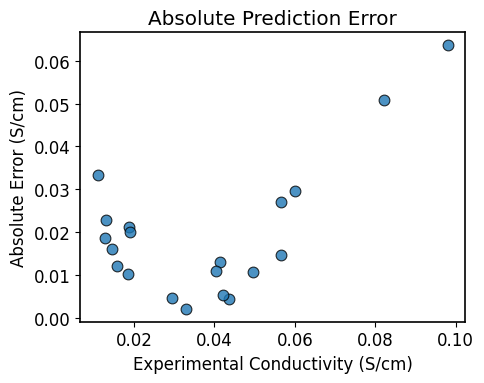

Saved figure: fig_absolute_error_external_strategy3.png


In [6]:
import matplotlib.pyplot as plt
import numpy as np

# -------------------------------
# Common settings
# -------------------------------
plt.rcParams.update({
    "font.size": 12,
    "axes.linewidth": 1.2
})

# -------------------------------
# Figure: Absolute error vs target
# -------------------------------
abs_err = np.abs(y_true - y_pred)

plt.figure(figsize=(5, 4))

plt.scatter(
    y_true,
    abs_err,
    s=60,
    edgecolor="black",
    linewidth=0.8,
    alpha=0.8
)

plt.xlabel("Experimental Conductivity (S/cm)")
plt.ylabel("Absolute Error (S/cm)")
plt.title("Absolute Prediction Error")

plt.tight_layout()
plt.savefig("fig_absolute_error_external_strategy3.png", dpi=300)
plt.show()

print("Saved figure: fig_absolute_error_external_strategy3.png")
